In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [44]:
df = pd.read_csv('Hitters.csv')

# Handle NULL values and eliminate unwanted columns
df = df.dropna()
unwanted_columns = ['League','Division','NewLeague']
df = df.drop(columns = unwanted_columns)

X = df.drop(columns = 'Salary')
y = df['Salary']

X_standard = (X - X.mean())/X.std()

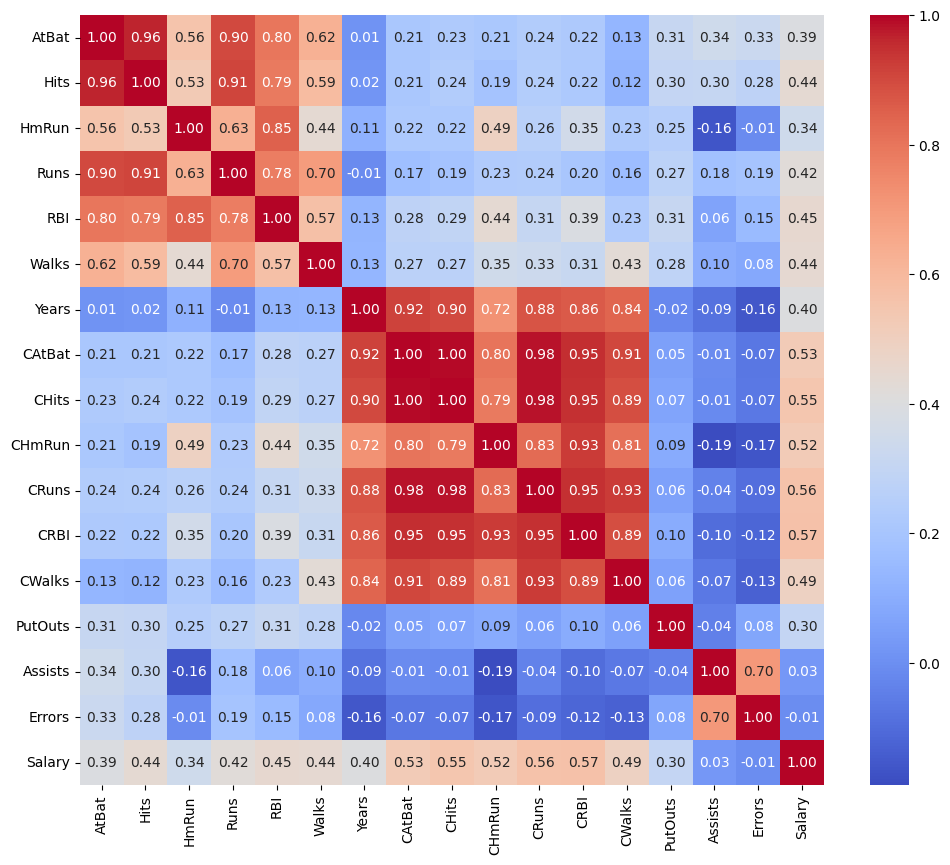

In [47]:
# Perform correlation analysis and visualize relationships
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [26]:
#PCA
cov_matrix = np.cov(X_standard, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Converting eigenvalues to explained variance ratios
explained_variance = eigenvalues / eigenvalues.sum()

cumulative_variance_explained = np.cumsum(explained_variance)

# Convert cumulative explained variance into percentages
cumulative_variance_explained_percentage = cumulative_variance_explained * 100

k=np.argmax(cumulative_variance_explained >= 0.975) + 1
print(k)

8


In [27]:
# Project the data onto the selected principal components
X_pca = X_standard.dot(eigenvectors[:, :k])

# Perform train-test split (adjust test_size as needed)
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        random.seed(random_state)

    data = list(zip(X, y))
    random.shuffle(data)

    split_index = int(len(data) * (1 - test_size))

    X_train, y_train = zip(*data[:split_index])
    X_test, y_test = zip(*data[split_index:])

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

X_train, X_test, y_train, y_test = train_test_split(X_pca.values, y.values, test_size=0.2, random_state=42)

In [28]:
def linear_regression(X_train, X_test, y_train, y_test):
    # Add a column of ones for the bias term
    X_train = np.c_[np.ones(X_train.shape[0]), X_train]
    X_test = np.c_[np.ones(X_test.shape[0]), X_test]

    # Calculate the coefficients using the normal equation
    theta = np.linalg.inv(X_train.T @ X_train) @ (X_train.T @ y_train)

    # Make predictions on training and testing sets
    y_train_pred = X_train @ theta
    y_test_pred = X_test @ theta

    # Calculate mean squared errors
    train_error = np.sqrt(np.mean((y_train - y_train_pred)**2))
    test_error = np.sqrt(np.mean((y_test - y_test_pred)**2))

    return train_error, test_error, theta

In [29]:
# Initialize variables to store results
rmse_values = []
best_rmse = (float('inf'),float('inf'))
best_component = None

# Loop through different numbers of principal components
for n_components in range(1, k + 1):
    # Build a regression model using n_components
    X_train_subset = X_train[:, :n_components]
    X_test_subset = X_test[:, :n_components]

    train_rmse,test_rmse,_ = linear_regression(X_train_subset,X_test_subset,y_train,y_test)
    rmse_values.append(test_rmse)

    if best_rmse[1]>test_rmse:
      best_rmse = (train_rmse,test_rmse)
      best_component = n_components


print(best_component)
print(best_rmse[1])
print(rmse_values)

6
277.0844471566575
[288.7698141858048, 284.5039050448121, 284.1856849021187, 279.4183716163413, 277.4795671532066, 277.0844471566575, 278.523096210158, 284.2468895722677]


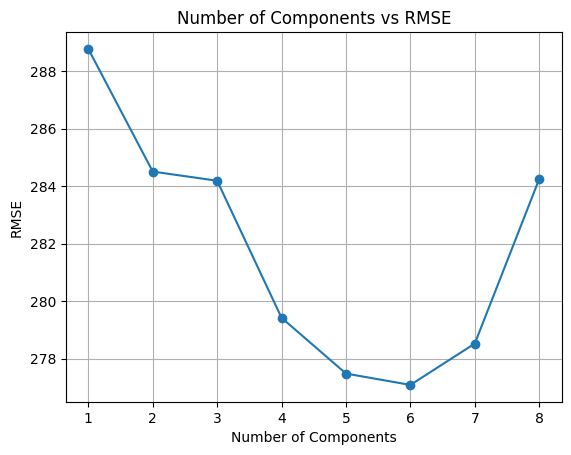

In [30]:
# Plot the graph
plt.plot(range(1, k + 1), rmse_values, marker='o')
plt.title('Number of Components vs RMSE')
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

In [42]:
#Optimal Model
X_train_final = X_train[:, :best_component]
X_test_final = X_test[:, :best_component]

train_rmse,test_rmse, weights = linear_regression(X_train_final,X_test_final,y_train,y_test)

# Extract the random point from X_test_final
X_test_final = np.c_[np.ones(X_test_final.shape[0]), X_test_final]
random_point = X_test_final[0, :]

y_prediction = random_point @ weights

predict_error = np.sqrt(np.mean(y_prediction - y_test[0])**2)

print(f"The specific point taken is : {random_point}")
print(f"The value of the specific point taken is : {y_test[0]}")
print(f"The predicted value is : {y_prediction}")
print(f"The error value is : {predict_error}")

The specific point taken is : [ 1.          0.86426493  0.56007646  0.89649062  0.35550739  0.13253904
 -0.22920269]
The value of the specific point taken is : 550.0
The predicted value is : 453.153653208603
The error value is : 96.84634679139702
